## SpotU

####  Following code contains the utility function to segregate the training + test data qand the Pytorch model training code


In [ ]:

# I did the training of my model on Google colab, hence there are some 
# codelines that are speciific to it and I have commented them out

# Parts of code have been taken from pytorch transfer learning tutorial : https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import shutil
plt.ion()   # interactive mode


In [0]:
# Intalling PyTorch
# !pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cpu/torch-1.4.0%2Bcpu-cp37-cp37m-win_amd64.whl
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.5.0%2Bcpu-cp37-cp37m-win_amd64.whl


### Utility function to segregate and label train and test images

In [ ]:
# Code to segregate images as per labels into test and train folders:

train_labels = pd.read_csv('train.csv',header=None)
test_labels = pd.read_csv('test.csv',header=None)
train_labels['train_test']= 'train'
test_labels['train_test']= 'test'
all_labels = train_labels.append(test_labels)

In [0]:
all_labels

,0,1,2,train_test
0,6591289cabd732f4,https://lh5.googleusercontent.com/-HKHFxqtYvwI...,1,train
1,8f2b466365e50d6d,https://lh4.googleusercontent.com/-6rGTjHhEMi8...,8,train
2,2fe21b965b35da1c,https://lh4.googleusercontent.com/-gSeO2IssDuI...,5,train
3,45173683aa7d1ae6,http://lh4.ggpht.com/-S2etEHP1ATo/ThLefufLm0I/...,0,train
4,a0057b550dbea8e2,https://lh6.googleusercontent.com/-HUDp4PV4d9I...,8,train
...,...,...,...,...
3312,98e1099024e676c8,https://lh3.googleusercontent.com/-qPpIltbXR1c...,5,test
3313,fbefc2f86dbe6716,https://lh4.googleusercontent.com/-1NGGf5eY0rc...,3,test
3314,5736ecd0c29b4800,http://lh4.ggpht.com/-knc36vhjMu4/TegfkJ5PaRI/...,3,test
3315,66158d4ef999dc76,http://lh3.ggpht.com/-oYOV1MQzPwE/Rp0g7KF5VmI/...,2,test


In [2]:
# Code used in Google colab to mount drive: To be ignored

# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#  Make empty directories for train and test and all labels
labels = train_labels[2].unique()
folders = ['train','test']
for f in folders:
    os.mkdir(f)
    for label in labels:
        os.mkdir(os.path.join(f,str(label)))

In [0]:
images = os.listdir('images')
images[:3]

['7d7e824bdd38b358.jpg', '1f6a0da0cf7c958f.jpg', 'ce258c094701c830.jpg']

In [0]:
# Copying images to respective folder
for image in images:
    if not all_labels[all_labels[0]+'.jpg' == image].empty:
        lab = all_labels[all_labels[0]+'.jpg' == image][2].iloc[0]
        cat = all_labels[all_labels[0]+'.jpg' == image]['train_test'].iloc[0]
        src_path = 'images/' + image
        dst_path = cat+'/' + str(lab) + '/'+ image
        shutil.copy(src_path, dst_path)

### Model Creation

### Step 1: Creating Data Transformer and Data Loaders

In [0]:
# Describe the data transformer, dataloaders etc
# I have set the batch size to '50'. This will need computational power(that is why I used Google Colab), 
# but will lead to a better accuracy as convergence can be reached must faster and better

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(x,
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=50,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Step 2: Function for data display as loaded to model

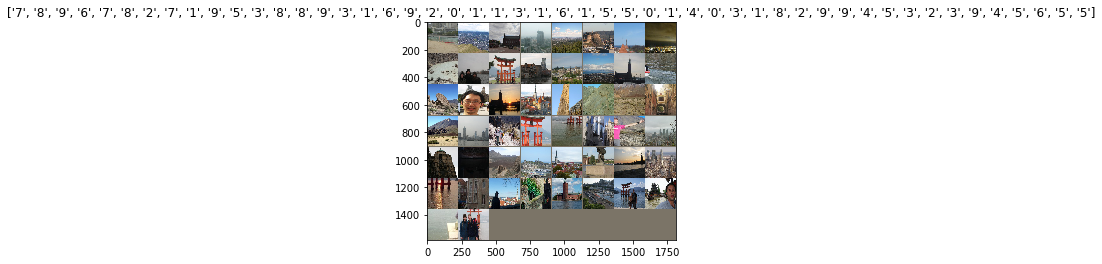

In [8]:
# Code taken from pytorch tutorial
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Step 3: Model function and training the Model

In [0]:
# General definition to train a model. I have changed the default number of epochs to 5

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
len(class_names)

10

In [12]:
# I have used a 'ConvNet as fixed feature extractor' approach in which we freeze all the network except the final layer.
# I chose this because it will be faster , and by just training the final layer, 
# I can utilize the pre-trained model to classify my own imageset. As restnet18 is itself trained on a variety of object images, 
# I believed it can be used as is for my use-case 

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features


model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [13]:
# Training the model: I chose 10 epochs
model_ft1 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5931 Acc: 0.8216
test Loss: 0.1784 Acc: 0.9463

Epoch 1/9
----------
train Loss: 0.2560 Acc: 0.9196
test Loss: 0.1023 Acc: 0.9726

Epoch 2/9
----------
train Loss: 0.2111 Acc: 0.9323
test Loss: 0.0887 Acc: 0.9753

Epoch 3/9
----------
train Loss: 0.1712 Acc: 0.9461
test Loss: 0.0642 Acc: 0.9840

Epoch 4/9
----------
train Loss: 0.1608 Acc: 0.9486
test Loss: 0.0597 Acc: 0.9831

Epoch 5/9
----------
train Loss: 0.1477 Acc: 0.9529
test Loss: 0.0487 Acc: 0.9888

Epoch 6/9
----------
train Loss: 0.1315 Acc: 0.9581
test Loss: 0.0487 Acc: 0.9876

Epoch 7/9
----------
train Loss: 0.1267 Acc: 0.9599
test Loss: 0.0423 Acc: 0.9907

Epoch 8/9
----------
train Loss: 0.1215 Acc: 0.9603
test Loss: 0.0410 Acc: 0.9894

Epoch 9/9
----------
train Loss: 0.1175 Acc: 0.9626
test Loss: 0.0429 Acc: 0.9885

Training complete in 14m 49s
Best val Acc: 0.990654


### Step 4: Display the Model Trained

In [14]:
model_ft1.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

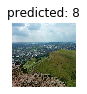

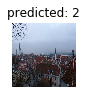

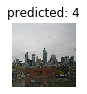

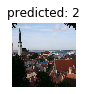

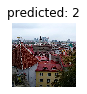

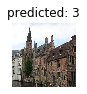

In [15]:
  visualize_model(model_ft1)

In [0]:
# Saving the model to my Drive from colab: To be ignored
# torch.save(model_ft1,'drive/My Drive/model_last_2')

In [17]:
# Loading model from drive to local: To be ignored 
# model_last_2 = torch.load('model_last_2',map_location=torch.device('cpu'))

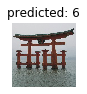

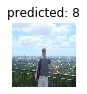

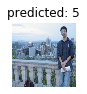

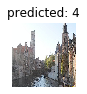

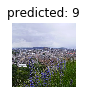

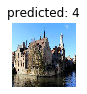

In [20]:
visualize_model(model_last_2)

In [20]:
# Code for getting labels and predictions on test data to ultimately create confusion matrix
model_last_2.eval()
predictions =[]
label_data=[]
with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_last_2(inputs)
            _, preds = torch.max(outputs, 1)
            print(inputs.size())
            for j in range(inputs.size()[0]):
                predictions.append(class_names[preds[j]])
                label_data.append(class_names[labels.data[j]])
    

torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size

In [29]:
# Raw Confusion Matrix
from sklearn.metrics import confusion_matrix as conf_mat

cf =conf_mat(label_data,predictions)
cf = pd.DataFrame(cf)
cf

,0,1,2,3,4,5,6,7,8,9
0,340,0,1,0,0,0,0,0,0,0
1,0,391,0,0,0,0,0,0,1,0
2,0,0,357,1,1,0,0,0,2,0
3,1,0,0,338,0,0,0,0,0,0
4,0,0,1,0,337,1,0,4,1,1
5,0,0,0,0,1,336,0,0,0,0
6,0,0,0,0,0,0,308,0,1,0
7,0,0,0,0,4,0,0,312,0,0
8,0,0,1,2,1,1,1,2,324,0
9,0,1,0,1,0,0,0,0,0,243


In [53]:
# Raw confusion Matrix with category names
cf.columns=['0. St. Stephan\'s Cathedral, Austria', '1. Teide, Spain', '2. Tallinn, Estonia','3. Brugge, Belgium',' 4. Montreal, Canada','5. Itsukushima Shrine, Japan','6. Shanghai, China','7. Brisbane, Australia','8. Edinburgh, Scotland','9. Stockholm, Sweden']
cf.index = ['0. St. Stephan\'s Cathedral, Austria', '1. Teide, Spain', '2. Tallinn, Estonia','3. Brugge, Belgium',' 4. Montreal, Canada','5. Itsukushima Shrine, Japan','6. Shanghai, China','7. Brisbane, Australia','8. Edinburgh, Scotland','9. Stockholm, Sweden']
cf

,"0. St. Stephan's Cathedral, Austria","1. Teide, Spain","2. Tallinn, Estonia","3. Brugge, Belgium","4. Montreal, Canada","5. Itsukushima Shrine, Japan","6. Shanghai, China","7. Brisbane, Australia","8. Edinburgh, Scotland","9. Stockholm, Sweden"
"0. St. Stephan's Cathedral, Austria",340,0,1,0,0,0,0,0,0,0
"1. Teide, Spain",0,391,0,0,0,0,0,0,1,0
"2. Tallinn, Estonia",0,0,357,1,1,0,0,0,2,0
"3. Brugge, Belgium",1,0,0,338,0,0,0,0,0,0
"4. Montreal, Canada",0,0,1,0,337,1,0,4,1,1
"5. Itsukushima Shrine, Japan",0,0,0,0,1,336,0,0,0,0
"6. Shanghai, China",0,0,0,0,0,0,308,0,1,0
"7. Brisbane, Australia",0,0,0,0,4,0,0,312,0,0
"8. Edinburgh, Scotland",0,0,1,2,1,1,1,2,324,0
"9. Stockholm, Sweden",0,1,0,1,0,0,0,0,0,243


In [54]:
# Normalized Confusion Matrix

cf_norm = cf.div(cf.sum(axis=1), axis=0)
cf_norm.columns= ['0. St. Stephan\'s Cathedral, Austria', '1. Teide, Spain', '2. Tallinn, Estonia','3. Brugge, Belgium',' 4. Montreal, Canada','5. Itsukushima Shrine, Japan','6. Shanghai, China','7. Brisbane, Australia','8. Edinburgh, Scotland','9. Stockholm, Sweden']
cf_norm.index= ['0. St. Stephan\'s Cathedral, Austria', '1. Teide, Spain', '2. Tallinn, Estonia','3. Brugge, Belgium',' 4. Montreal, Canada','5. Itsukushima Shrine, Japan','6. Shanghai, China','7. Brisbane, Australia','8. Edinburgh, Scotland','9. Stockholm, Sweden']
cf_norm

,"0. St. Stephan's Cathedral, Austria","1. Teide, Spain","2. Tallinn, Estonia","3. Brugge, Belgium","4. Montreal, Canada","5. Itsukushima Shrine, Japan","6. Shanghai, China","7. Brisbane, Australia","8. Edinburgh, Scotland","9. Stockholm, Sweden"
"0. St. Stephan's Cathedral, Austria",0.997067,0.000000,0.002933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"1. Teide, Spain",0.000000,0.997449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002551,0.000000
"2. Tallinn, Estonia",0.000000,0.000000,0.988920,0.002770,0.002770,0.000000,0.000000,0.000000,0.005540,0.000000
"3. Brugge, Belgium",0.002950,0.000000,0.000000,0.997050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"4. Montreal, Canada",0.000000,0.000000,0.002899,0.000000,0.976812,0.002899,0.000000,0.011594,0.002899,0.002899
"5. Itsukushima Shrine, Japan",0.000000,0.000000,0.000000,0.000000,0.002967,0.997033,0.000000,0.000000,0.000000,0.000000
"6. Shanghai, China",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996764,0.000000,0.003236,0.000000
"7. Brisbane, Australia",0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.000000,0.987342,0.000000,0.000000
"8. Edinburgh, Scotland",0.000000,0.000000,0.003012,0.006024,0.003012,0.003012,0.003012,0.006024,0.975904,0.000000
"9. Stockholm, Sweden",0.000000,0.004082,0.000000,0.004082,0.000000,0.000000,0.000000,0.000000,0.000000,0.991837


In [56]:
#  Calculate precision and recall per category
from sklearn.metrics import precision_recall_fscore_support
metrics = precision_recall_fscore_support(label_data, predictions, average=None)
print(metrics)
precision_per_label = metrics[0]
recall_per_label = metrics[1]

(array([0.99706745, 0.99744898, 0.99166667, 0.98830409, 0.97965116,
        0.99408284, 0.99676375, 0.98113208, 0.98480243, 0.99590164]),
 array([0.99706745, 0.99744898, 0.98891967, 0.99705015, 0.97681159,
        0.99703264, 0.99676375, 0.98734177, 0.97590361, 0.99183673]),
 array([0.99706745, 0.99744898, 0.99029126, 0.99265786, 0.97822932,
        0.99555556, 0.99676375, 0.98422713, 0.98033283, 0.99386503]),
 array([341, 392, 361, 339, 345, 337, 309, 316, 332, 245], dtype=int64))

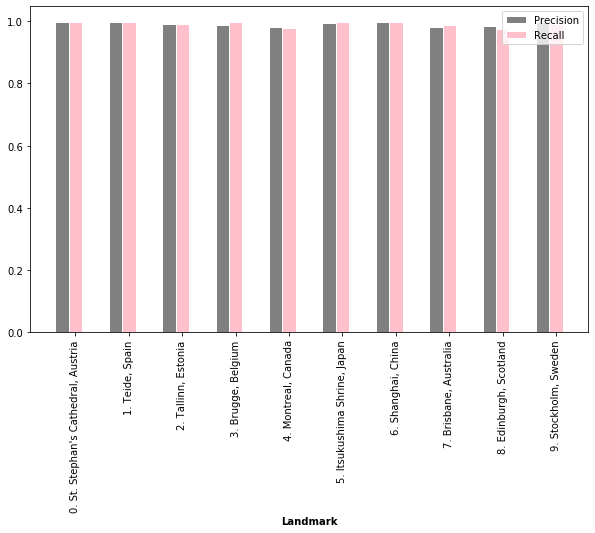

In [50]:
# Plot grouped bargraph
# Some inspiration for code taken from : https://python-graph-gallery.com/11-grouped-barplot/
import numpy as np
import matplotlib.pyplot as plt
barWidth = 0.25
plt.figure(figsize=(10,6))
r1 = np.arange(len(precision_per_label))
r2 = [x + barWidth for x in r1]
plt.bar(r1, precision_per_label, color='gray', width=barWidth, edgecolor='white', label='Precision')
plt.bar(r2, recall_per_label, color='pink', width=barWidth, edgecolor='white', label='Recall')
plt.xlabel('Landmark', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(precision_per_label))], ['0. St. Stephan\'s Cathedral, Austria', '1. Teide, Spain', '2. Tallinn, Estonia','3. Brugge, Belgium',' 4. Montreal, Canada','5. Itsukushima Shrine, Japan','6. Shanghai, China','7. Brisbane, Australia','8. Edinburgh, Scotland','9. Stockholm, Sweden'],rotation =90)
plt.legend()
plt.show()
 
